# Medicare Stars Project

In [2]:
# I imported the data from Data.CMS.gov -- the Provider Information dataset. 
# Objective: to discover any existing trends in star ratings (overall quality) over time and investigate factors that affect the ratings-- in particular,
# health inspections, quality measures, and staffing.

### Data Analysis

#### Data Cleaning

In [3]:
%pip install scipy


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import altair as alt
import plotly.express as px
import os, json
import matplotlib.pyplot as plt 
from scipy.stats import f_oneway, permutation_test

provider_info = pd.read_csv('provider_info.csv')
provider_info.head()

CMS Certification Number (CCN)                                Provider Name  \
0                         015009                     BURNS NURSING HOME, INC.   
1                         015010               COOSA VALLEY HEALTHCARE CENTER   
2                         015012                   HIGHLANDS HEALTH AND REHAB   
3                         015014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                         015015                PLANTATION MANOR NURSING HOME   

              Provider Address     City/Town State  ZIP Code  \
0         701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1       260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2          380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3     7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4  6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   

   Telephone Number  Provider SSA County Code County/Parish  \
0        2563324110                       290      Franklin   
1        2562495604                       600     Talladega   
2        2562183708                       350       Jackson   
3        2058330146                       360     Jefferson   
4        2054776161                       360     Jefferson   

             Ownership Type  ...  \
0  For profit - Corporation  ...   
1  For profit - Corporation  ...   
2       Government - County  ...   
3   For profit - Individual  ...   
4   For profit - Individual  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0                                                NaN                     2   
1                                                0.0                     0   
2                                                NaN                     0   
3                                                0.0                     0   
4                                                NaN                     0   

   Total Amount of Fines in Dollars Number of Payment Denials  \
0                          24644.14                         0   
1                              0.00                         0   
2                              0.00                         0   
3                              0.00                         0   
4                              0.00                         0   

  Total Number of Penalties                                       Location  \
0                         2     701 MONROE STREET NW,RUSSELLVILLE,AL,35653   
1                         0      260 WEST WALNUT STREET,SYLACAUGA,AL,35150   
2                         0        380 WOODS COVE ROAD,SCOTTSBORO,AL,35768   
3                         0   7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206   
4                         0  6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111   

  Latitude Longitude  Geocoding Footnote Processing Date  
0  34.5149   -87.736                 NaN      2024-07-01  
1  33.1637   -86.254                 NaN      2024-07-01  
2  34.6611   -86.047                 NaN      2024-07-01  
3  33.5595   -86.722                 NaN      2024-07-01  
4  33.3221   -87.034                 NaN      2024-07-01  

[5 rows x 103 columns]

In [5]:
provider_info[provider_info['Staffing Rating'].isna()]

CMS Certification Number (CCN)  \
133                           015217   
227                           025019   
232                           025026   
235                           025030   
303                           035146   
...                              ...   
14491                         676132   
14791                         676476   
14818                         686127   
14831                         745038   
14832                         745039   

                                       Provider Name  \
133    BIRMINGHAM NURSING AND REHABILITATION CTR LLC   
227                    PETERSBURG MEDICAL CENTER LTC   
232                              QUYANNA CARE CENTER   
235                 PROVIDENCE KODIAK ISLAND MED LTC   
303              LIFE CARE CENTER OF PARADISE VALLEY   
...                                              ...   
14491            TRAIL LAKE NURSING & REHABILITATION   
14791                    THE HEIGHTS ON VALLEY RANCH   
14818                            ADVENTHEALTH DELAND   
14831  TIERRA ESTE NURSING AND REHABILITATION CENTER   
14832              MIDTOWNE MEADOWS HEALTH AND REHAB   

                 Provider Address   City/Town State  ZIP Code  \
133             1000 DUGAN AVENUE  BIRMINGHAM    AL     35214   
227               103 FRAM STREET  PETERSBURG    AK     99833   
232     1100 GREG KRUSCHEK AVENUE        NOME    AK     99762   
235          1915 E REZANOF DRIVE      KODIAK    AK     99615   
303           4065 EAST BELL ROAD     PHOENIX    AZ     85032   
...                           ...         ...   ...       ...   
14491          7100 TRAIL LAKE DR  FORT WORTH    TX     76133   
14791  23200 VALLEY RANCH PARKWAY      PORTER    TX     77365   
14818          701 W PLYMOUTH AVE      DELAND    FL     32720   
14831     14300 PEBBLE HILLS BLVD     EL PASO    TX     79938   
14832               110 DYLAN WAY  MIDLOTHIAN    TX     76065   

       Telephone Number  Provider SSA County Code          County/Parish  \
133          2057988780                       360              Jefferson   
227          9077724291                       195     Petersburg Borough   
232          9074433311                       180                   Nome   
235          9074867800                       150  Kodiak Island Borough   
303          6028670212                        60               Maricopa   
...                 ...                       ...                    ...   
14491        8172632224                       910                Tarrant   
14791        3463265085                       801             Montgomery   
14818        3869434522                       630                Volusia   
14831        9159559998                       480                El Paso   
14832              1111                       470                  Ellis   

                               Ownership Type  ...  \
133    For profit - Limited Liability company  ...   
227                  Government - City/county  ...   
232                  Non profit - Corporation  ...   
235                  Non profit - Corporation  ...   
303                  For profit - Corporation  ...   
...                                       ...  ...   
14491  For profit - Limited Liability company  ...   
14791  For profit - Limited Liability company  ...   
14818                Non profit - Corporation  ...   
14831                For profit - Corporation  ...   
14832  For profit - Limited Liability company  ...   

       Number of Citations from Infection Control Inspections  \
133                                                  0.0        
227                                                  NaN        
232                                                  NaN        
235                                                  NaN        
303                                                  0.0        
...                                                  ...        
14491                                                9

In [6]:
# We have a lot of missing data! I will impute the NaN values by calculating the mean values for each state and filling them in respectively. 
def removeNA(col):
    citations_present = provider_info[~provider_info[col].isna()]
    mean_citations_state = citations_present[['State', col]].groupby('State').mean()
    mean_citations_state_dict = mean_citations_state[col].to_dict()
    return mean_citations_state_dict

infection_control_dict = removeNA('Number of Citations from Infection Control Inspections')
health_inspection_dict = removeNA('Health Inspection Rating')
average_resident_num_dict = removeNA('Average Number of Residents per Day')
overall_rating_dict = removeNA('Overall Rating')
qm_rating_dict = removeNA('QM Rating')
staffing_rating_dict = removeNA('Staffing Rating')

In [7]:
def fillNA(col, state_mean_dct):
    provider_info[col] = provider_info[col].fillna(provider_info['State'].map(state_mean_dct))
    return provider_info
provider_info = fillNA('Number of Citations from Infection Control Inspections', infection_control_dict)
provider_info = fillNA('Average Number of Residents per Day', average_resident_num_dict)
provider_info = fillNA('Overall Rating', overall_rating_dict)
provider_info = fillNA('QM Rating', qm_rating_dict)
provider_info = fillNA('Staffing Rating', staffing_rating_dict)
provider_info = fillNA('Health Inspection Rating', health_inspection_dict)

smaller_provider_info = provider_info[['CMS Certification Number (CCN)', 'State', 'Ownership Type', 'Number of Certified Beds', 'Average Number of Residents per Day', \
                                       'Provider Type', 'Special Focus Status', 'Abuse Icon', 'Overall Rating', 'Health Inspection Rating',\
                                        'QM Rating', 'Staffing Rating', 'Number of Citations from Infection Control Inspections', 'Total Amount of Fines in Dollars']]
smaller_provider_info.head()

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN          N             2.0   
1  Medicare and Medicaid                  NaN          N             4.0   
2  Medicare and Medicaid                  NaN          N             4.0   
3  Medicare and Medicaid                  NaN          N             2.0   
4  Medicare and Medicaid                  NaN          N             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [8]:
# Let's replace all the 'N' in the 'Abuse Icon' with 0. We will also replace all the 'Y' in this column with 1 to make statistical analysis easier.
smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('N', 0)
smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('Y', 1)
smaller_provider_info.head()

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_25831/2116436996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('N', 0)
/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_25831/2116436996.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  smaller_provider_info['Abuse Icon'] = smaller_provider_info['Abuse Icon'].replace('Y', 1)
/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_25831/2116436996.py:3: Settin

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN           0             2.0   
1  Medicare and Medicaid                  NaN           0             4.0   
2  Medicare and Medicaid                  NaN           0             4.0   
3  Medicare and Medicaid                  NaN           0             2.0   
4  Medicare and Medicaid                  NaN           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

#### Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [9]:
qm_mean = smaller_provider_info['QM Rating'].mean()
qm_mean

np.float64(3.5042665950143994)

In [10]:
qm_median = smaller_provider_info['QM Rating'].median()
qm_median

np.float64(4.0)

Because the mean < median, the distribution is left skewed. Most providers receive high ratings but there are a few outliers with low ratings.

In [11]:
qm_mode = smaller_provider_info['QM Rating'].mode()
qm_mode

0    5.0
Name: QM Rating, dtype: float64

Although the median is 4.0, the most common score providers get is 5.0.

In [12]:
#27.94% of the providers got a score of 5.0
len(smaller_provider_info[smaller_provider_info['QM Rating'] == 5]) / smaller_provider_info.shape[0]

0.27942564379129026

In [13]:
# percentages by state
smaller_provider_info['State'].value_counts(normalize = True)

State
TX    0.079817
CA    0.078468
OH    0.062626
FL    0.047121
IL    0.045975
PA    0.045167
NY    0.040650
IN    0.034515
MO    0.033369
MI    0.028650
NC    0.028246
IA    0.027235
GA    0.024066
NJ    0.023325
MA    0.023257
MN    0.023123
WI    0.021977
KS    0.020561
TN    0.020493
VA    0.019550
OK    0.019347
KY    0.018134
LA    0.018067
AL    0.015100
MD    0.014966
AR    0.014831
CO    0.014224
MS    0.013617
CT    0.013280
WA    0.013011
SC    0.012741
NE    0.012404
AZ    0.009573
OR    0.008629
WV    0.008292
UT    0.006606
SD    0.006539
ME    0.005460
ID    0.005393
ND    0.005056
NH    0.004989
RI    0.004989
NM    0.004584
NV    0.004517
MT    0.004045
DE    0.002966
HI    0.002831
WY    0.002359
VT    0.002292
AK    0.001348
DC    0.001146
PR    0.000404
GU    0.000067
Name: proportion, dtype: float64

In [14]:
# percentages by ownership type
# In order from most to least: for profit, non-profit, government
smaller_provider_info['Ownership Type'].value_counts(normalize = True)

Ownership Type
For profit - Corporation                  0.394297
For profit - Limited Liability company    0.243832
Non profit - Corporation                  0.168801
For profit - Individual                   0.050492
For profit - Partnership                  0.035998
Government - County                       0.025886
Non profit - Other                        0.021302
Non profit - Church related               0.021302
Government - Hospital district            0.018201
Government - State                        0.010516
Government - City                         0.004045
Government - City/county                  0.003977
Government - Federal                      0.001348
Name: proportion, dtype: float64

##### Data Distribution

In [15]:
smaller_provider_info.head()

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN           0             2.0   
1  Medicare and Medicaid                  NaN           0             4.0   
2  Medicare and Medicaid                  NaN           0             4.0   
3  Medicare and Medicaid                  NaN           0             2.0   
4  Medicare and Medicaid                  NaN           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [16]:
fines_boxplot = px.box(smaller_provider_info, x = 'Total Amount of Fines in Dollars')
fines_boxplot

In [17]:
infections_citations_boxplot = px.box(smaller_provider_info, x = 'Number of Citations from Infection Control Inspections')
infections_citations_boxplot

##### Geographic Analysis

In [18]:
# QM (quality measure) map on USA
qm_rating = smaller_provider_info.groupby('State')[['QM Rating']].mean().sort_values(by = 'QM Rating', ascending = False).reset_index()
qm_rating.head()

State  QM Rating
0    HI   4.658537
1    NJ   4.438235
2    UT   4.371134
3    CA   4.328371
4    ID   4.282051

In [19]:
qm_state_graph = px.choropleth(
    qm_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'QM Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average QM Rating by State'
)
qm_state_graph

In [20]:
provider_info.head()

CMS Certification Number (CCN)                                Provider Name  \
0                         015009                     BURNS NURSING HOME, INC.   
1                         015010               COOSA VALLEY HEALTHCARE CENTER   
2                         015012                   HIGHLANDS HEALTH AND REHAB   
3                         015014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                         015015                PLANTATION MANOR NURSING HOME   

              Provider Address     City/Town State  ZIP Code  \
0         701 MONROE STREET NW  RUSSELLVILLE    AL     35653   
1       260 WEST WALNUT STREET     SYLACAUGA    AL     35150   
2          380 WOODS COVE ROAD    SCOTTSBORO    AL     35768   
3     7755 FOURTH AVENUE SOUTH    BIRMINGHAM    AL     35206   
4  6450 OLD TUSCALOOSA HIGHWAY      MC CALLA    AL     35111   

   Telephone Number  Provider SSA County Code County/Parish  \
0        2563324110                       290      Franklin   
1        2562495604                       600     Talladega   
2        2562183708                       350       Jackson   
3        2058330146                       360     Jefferson   
4        2054776161                       360     Jefferson   

             Ownership Type  ...  \
0  For profit - Corporation  ...   
1  For profit - Corporation  ...   
2       Government - County  ...   
3   For profit - Individual  ...   
4   For profit - Individual  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0                                           0.717391                     2   
1                                           0.000000                     0   
2                                           0.717391                     0   
3                                           0.000000                     0   
4                                           0.717391                     0   

   Total Amount of Fines in Dollars Number of Payment Denials  \
0                          24644.14                         0   
1                              0.00                         0   
2                              0.00                         0   
3                              0.00                         0   
4                              0.00                         0   

  Total Number of Penalties                                       Location  \
0                         2     701 MONROE STREET NW,RUSSELLVILLE,AL,35653   
1                         0      260 WEST WALNUT STREET,SYLACAUGA,AL,35150   
2                         0        380 WOODS COVE ROAD,SCOTTSBORO,AL,35768   
3                         0   7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206   
4                         0  6450 OLD TUSCALOOSA HIGHWAY,MC CALLA,AL,35111   

  Latitude Longitude  Geocoding Footnote Processing Date  
0  34.5149   -87.736                 NaN      2024-07-01  
1  33.1637   -86.254                 NaN      2024-07-01  
2  34.6611   -86.047                 NaN      2024-07-01  
3  33.5595   -86.722                 NaN      2024-07-01  
4  33.3221   -87.034                 NaN      2024-07-01  

[5 rows x 103 columns]

In [21]:
qm_rating_counties = provider_info.groupby(['State', 'Latitude', 'Longitude', 'County/Parish'])[['QM Rating']].mean().reset_index()
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'qm_rating_counties.csv')
qm_rating_counties.to_csv(file_path, index=False)
qm_rating_counties.head()

State  Latitude  Longitude          County/Parish  QM Rating
0    AK   55.3119   -131.587      Ketchikan Gateway        5.0
1    AK   56.4575   -132.369               Wrangell        4.0
2    AK   56.8125   -132.956     Petersburg Borough        4.0
3    AK   57.0594   -135.344          Sitka Borough        4.0
4    AK   57.8010   -152.374  Kodiak Island Borough        4.0

In [22]:
with open('qm_rating.geojson') as f:
    geojson_data = json.load(f)

In [23]:
fig = px.scatter_geo(
    qm_rating_counties,
    lon='Longitude',
    lat='Latitude',
    color='QM Rating',
    color_continuous_scale="RdBu",
    title="Choropleth Map of QM Ratings by Provider Sites Across the U.S.",
    scope = 'usa'
)
fig

In [24]:
# staffing rating map on USA
staffing_rating = smaller_provider_info.groupby('State')[['Staffing Rating']].mean().sort_values(by = 'Staffing Rating', ascending = False).reset_index()
staffing_rating_graph = px.choropleth(
    staffing_rating,
    locations = 'State',
    locationmode= 'USA-states',
    color = 'Staffing Rating',
    color_continuous_scale= 'RdBu',
    scope = 'usa',
    title = 'Average Staffing Rating by State'
)
staffing_rating_graph

In [25]:
provider_info[(provider_info['County/Parish']=='Contra Costa')].head()

CMS Certification Number (CCN)                  Provider Name  \
625                         055049       PLEASANT HILL POST ACUTE   
639                         055085              MORAGA POST ACUTE   
642                         055099    CREEKSIDE HEALTHCARE CENTER   
662                         055150       DIABLO VALLEY POST ACUTE   
704                         055241  WILLOW PASS HEALTHCARE CENTER   

            Provider Address      City/Town State  ZIP Code  Telephone Number  \
625  1625 OAK PARK BOULEVARD  PLEASANT HILL    CA     94523        9259355222   
639      348 RHEEM BOULEVARD         MORAGA    CA     94556        9253765995   
642         1900 CHURCH LANE      SAN PABLO    CA     94806        5102355514   
662        3806 CLAYTON ROAD        CONCORD    CA     94521        9256892266   
704    3318 WILLOW PASS ROAD        CONCORD    CA     94519        9256899222   

     Provider SSA County Code County/Parish  \
625                        60  Contra Costa   
639                        60  Contra Costa   
642                        60  Contra Costa   
662                        60  Contra Costa   
704                        60  Contra Costa   

                             Ownership Type  ...  \
625  For profit - Limited Liability company  ...   
639                For profit - Corporation  ...   
642                For profit - Corporation  ...   
662  For profit - Limited Liability company  ...   
704                For profit - Corporation  ...   

     Number of Citations from Infection Control Inspections  Number of Fines  \
625                                           1.122085                     0   
639                                           1.000000                     3   
642                                           1.122085                     0   
662                                           1.122085                     0   
704                                           0.000000                     3   

     Total Amount of Fines in Dollars Number of Payment Denials  \
625                              0.00                         0   
639                          11346.74                         0   
642                              0.00                         0   
662                              0.00                         0   
704                          17380.18                         1   

    Total Number of Penalties                                        Location  \
625                         0  1625 OAK PARK BOULEVARD,PLEASANT HILL,CA,94523   
639                         3             348 RHEEM BOULEVARD,MORAGA,CA,94556   
642                         0             1900 CHURCH LANE,SAN PABLO,CA,94806   
662                         0              3806 CLAYTON ROAD,CONCORD,CA,94521   
704                         4          3318 WILLOW PASS ROAD,CONCORD,CA,94519   

    Latitude Longitude  Geocoding Footnote Processing Date  
625  37.9332  -122.063                 NaN      2024-07-01  
639  37.8615  -122.129                 NaN      2024-07-01  
642  37.9573  -122.342                 NaN      2024-07-01  
662  37.9690  -122.005                 NaN      2024-07-01  
704  37.9825  -122.017                 NaN      2024-07-01  

[5 rows x 103 columns]

##### Correlation Analysis

In [26]:
# Correlation between number of certified beds and the average number of residents per day
# Very strong association between the 2 variables
# Facilities with more certified beds can take more residents per day
smaller_provider_info['Number of Certified Beds'].corr(smaller_provider_info['Average Number of Residents per Day'])

np.float64(0.9028575927563955)

In [27]:
# We need to create a subset of the data since Altair can handle at max 5,000 rows. 
# There are 50 states + 3 territories = 53, so we will take 5000 // 53 = 94 rows from each region. 
len(smaller_provider_info['State'].unique())

53

In [28]:
subset = smaller_provider_info.groupby('State').head(94)

In [29]:
alt.Chart(subset).mark_circle().encode(
    x = 'Number of Certified Beds',
    y = 'Average Number of Residents per Day',
    color = alt.Color('Overall Rating', scale=alt.Scale(scheme='redblue')),
    tooltip=['Average Number of Residents per Day', 'Number of Certified Beds', 'Overall Rating']
    ).interactive()

alt.Chart(...)

In [30]:
# Correlation between the types of ratings that contribute to the overall rating
# Moderate positive association between QM & overall rating; staffing & overall rating
# Very strong positive association between health inspection & overall rating
rating_columns = ['Overall Rating', 'Health Inspection Rating', 'QM Rating', 'Staffing Rating']
smaller_provider_info[rating_columns].corr()

Overall Rating  Health Inspection Rating  QM Rating  \
Overall Rating                  1.000000                  0.884151   0.455132   
Health Inspection Rating        0.884151                  1.000000   0.199962   
QM Rating                       0.455132                  0.199962   1.000000   
Staffing Rating                 0.503259                  0.318621   0.137140   

                          Staffing Rating  
Overall Rating                   0.503259  
Health Inspection Rating         0.318621  
QM Rating                        0.137140  
Staffing Rating                  1.000000

In [31]:
scatterplot = alt.Chart(subset).mark_circle().encode(
    x = 'Health Inspection Rating',
    y = alt.Y('Overall Rating', title = 'Overall Quality Rating'),
    tooltip=['Health Inspection Rating', 'Overall Rating']
    ).interactive()
line = scatterplot.transform_regression('Health Inspection Rating', 'Overall Rating').mark_line(color='red')

scatterplot + line

alt.LayerChart(...)

In [32]:
# Weak positive association between citations & fines
smaller_provider_info['Number of Citations from Infection Control Inspections'].corr(smaller_provider_info['Total Amount of Fines in Dollars'])

np.float64(0.20053019441258518)

In [33]:
# Negative weak association between fines & overall rating
beds_rating_cols = ['Total Amount of Fines in Dollars', 'Overall Rating']
provider_info[beds_rating_cols].corr()

Total Amount of Fines in Dollars  \
Total Amount of Fines in Dollars                          1.000000   
Overall Rating                                           -0.375909   

                                  Overall Rating  
Total Amount of Fines in Dollars       -0.375909  
Overall Rating                          1.000000

#### Statistical Analysis

**Question of Interest:** Does the total amount of fines in dollars significantly predict the overall rating?

In [34]:
# Ensure that all the ratings are integers and either 1, 2, 3, 4, or 5
smaller_provider_info['Overall Rating'] = round(smaller_provider_info['Overall Rating'])

/var/folders/5l/vsm1wvjn4qdg25qwjfcj83kr0000gn/T/ipykernel_25831/3534437720.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**H&#8320;:** &mu;&#8321; = &mu;&#8322; = &mu;&#8323; = &mu;&#8324; = &mu;&#8325;, where each &mu; is the mean of the rating for each category

The mean number of fines is the same for each overall rating.

**H&#8321;:** Some &mu; are different.

There is a difference in the mean number of fines for 1+ categories of overall rating.

We will conduct an ANOVA test since we are comparing the mean number of fines for 3+ categories.

In [50]:
groups = [
    subset[subset['Overall Rating'].isin(range(1, 4))]['Total Amount of Fines in Dollars'],
    subset[subset['Overall Rating'].isin(range(4, 6))]['Total Amount of Fines in Dollars']
]
observed_f, _ = f_oneway(*groups) # f-stat = 243.55

# n_permutations = 10_000
# permuted_f_stats = []

# for _ in range(n_permutations):
#     copy = subset.copy()
#     copy['Total_Fines_shuffled'] = np.random.permutation(copy['Total Amount of Fines in Dollars'])
#     shuffled_groups = [
#         copy[copy['Overall Rating'].isin(range(1, 4))]['Total_Fines_shuffled'],
#         copy[copy['Overall Rating'].isin(range(4, 6))]['Total_Fines_shuffled']
#     ]
#     permuted_f, _ = f_oneway(*shuffled_groups)
#     permuted_f_stats.append(permuted_f)
#     print(permuted_f)
observed_f

np.float64(336.0205300543837)

In [36]:
subset.head()

CMS Certification Number (CCN) State            Ownership Type  \
0                         015009    AL  For profit - Corporation   
1                         015010    AL  For profit - Corporation   
2                         015012    AL       Government - County   
3                         015014    AL   For profit - Individual   
4                         015015    AL   For profit - Individual   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 50.0   
1                        85                                 76.9   
2                        50                                 45.1   
3                        92                                 76.9   
4                       103                                 86.6   

           Provider Type Special Focus Status  Abuse Icon  Overall Rating  \
0  Medicare and Medicaid                  NaN           0             2.0   
1  Medicare and Medicaid                  NaN           0             4.0   
2  Medicare and Medicaid                  NaN           0             4.0   
3  Medicare and Medicaid                  NaN           0             2.0   
4  Medicare and Medicaid                  NaN           0             2.0   

   Health Inspection Rating  QM Rating  Staffing Rating  \
0                       2.0        4.0              4.0   
1                       4.0        4.0              3.0   
2                       4.0        2.0              3.0   
3                       3.0        3.0              1.0   
4                       2.0        2.0              4.0   

   Number of Citations from Infection Control Inspections  \
0                                           0.717391        
1                                           0.000000        
2                                           0.717391        
3                                           0.000000        
4                                           0.717391        

   Total Amount of Fines in Dollars  
0                          24644.14  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [52]:
# We will use the subsets dataframe again to speed up the permutation process
groups = [subset[subset['Overall Rating'] == cat]['Total Amount of Fines in Dollars'] for cat in range(1, 6)]

observed_f, _ = f_oneway(*groups) # f-stat = 243.55

n_permutations = 10_000
permuted_f_stats = []

for _ in range(n_permutations):
    copy = subset.copy()
    copy['Total_Fines_shuffled'] = np.random.permutation(copy['Total Amount of Fines in Dollars'])
    shuffled_groups = [copy[copy['Overall Rating']== cat]['Total_Fines_shuffled'] for cat in range(1, 6)]
    permuted_f, _ = f_oneway(*shuffled_groups)
    permuted_f_stats.append(permuted_f)
    print(permuted_f)

p = np.mean(np.array(permuted_f_stats) >= observed_f)

print("Observed F-value:", observed_f) #f-stat: 243.55
print("Permuted F-values range:", min(permuted_f_stats), "to", max(permuted_f_stats)) # permuted f-stats: 0.004 to 6.433
print(p)


0.6509835471729603
1.2839857048208279
1.2114255415281379
0.3323646991845879
1.5080785904927425
3.39367837538723
1.457309404178031
1.914987376171924
2.3088767393500724
0.2266505169822323
0.9920899625541639
1.0059626830745467
0.20261996774617458
1.7849586673317472
1.5620545762561135
0.8319196473306615
0.3616959211724779
0.5814058320869995
1.9912603152647297
0.4172682143766632
0.07157913685398118
1.170511484226461
2.5586975979663698
0.7803660438117755
0.9976034395320903
0.44258614598391177
2.8906629961036403
0.8996935707224181
3.0797581554088485
1.2411784544164102
0.6026669663945913
1.1435644175421316
1.3746518653006925
0.5148627909375658
1.1746373545438689
1.3510381077305464
0.9054979123508471
2.463875082880059
1.470453892398838
0.789357114763941
0.4621093905757679
0.2719304456644615
0.4498431918353685
0.4343540687424431
1.3098527302910197
0.7457509762841389
1.1304827884558974
0.38405290166798794
0.5992253731965289
1.3400520289808568
0.8428432281848435
0.2185225322359884
1.16970669322607

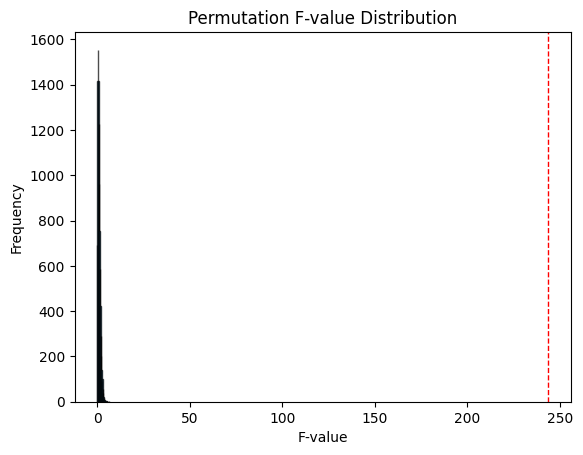

In [53]:
plt.hist(permuted_f_stats, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(observed_f, color='r', linestyle='dashed', linewidth=1)
plt.title('Permutation F-value Distribution')
plt.xlabel('F-value')
plt.ylabel('Frequency')
plt.show()


Because p = 0 < 0.05, we reject the null hypothesis, so the mean total fines is significantly different for each category.